In [6]:
import numpy as np


class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [7]:
from sklearn.datasets import load_boston

In [8]:
data = load_boston()

In [9]:
losses = []

In [10]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 185.968
Epoch: 101, Loss: 9.428
Epoch: 201, Loss: 5.218
Epoch: 301, Loss: 4.804
Epoch: 401, Loss: 6.067
Epoch: 501, Loss: 4.659
Epoch: 601, Loss: 4.149
Epoch: 701, Loss: 4.608
Epoch: 801, Loss: 4.080
Epoch: 901, Loss: 4.129
Epoch: 1001, Loss: 4.334
Epoch: 1101, Loss: 4.135
Epoch: 1201, Loss: 4.338
Epoch: 1301, Loss: 4.243
Epoch: 1401, Loss: 4.025
Epoch: 1501, Loss: 4.067
Epoch: 1601, Loss: 4.640
Epoch: 1701, Loss: 4.232
Epoch: 1801, Loss: 4.482
Epoch: 1901, Loss: 3.983
Epoch: 2001, Loss: 4.645
Epoch: 2101, Loss: 4.485
Epoch: 2201, Loss: 4.217
Epoch: 2301, Loss: 3.786
Epoch: 2401, Loss: 3.629
Epoch: 2501, Loss: 4.461
Epoch: 2601, Loss: 4.645
Epoch: 2701, Loss: 3.421
Epoch: 2801, Loss: 4.928
Epoch: 2901, Loss: 3.717
Epoch: 3001, Loss: 3.617
Epoch: 3101, Loss: 4.249
Epoch: 3201, Loss: 3.880
Epoch: 3301, Loss: 4.549
Epoch: 3401, Loss: 3.278
Epoch: 3501, Loss: 3.366
Epoch: 3601, Loss: 3.861
Epoch: 3701, Loss: 4.050
Epoch: 3801, Loss: 4.686
Epoc

In [27]:
np.zeros(1)

array([0.])

In [22]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [11]:
forward(l2,graph)

array([[17.87388752],
       [14.73623214],
       [ 8.68599711],
       [28.26256191],
       [15.49375025],
       [27.64928613],
       [25.75003666],
       [24.13191888],
       [25.80691813],
       [14.00489878],
       [ 7.17104549],
       [18.77167354],
       [27.88588291],
       [26.53172623],
       [19.29746179],
       [20.35543878]])

In [12]:
import matplotlib.pyplot as plt

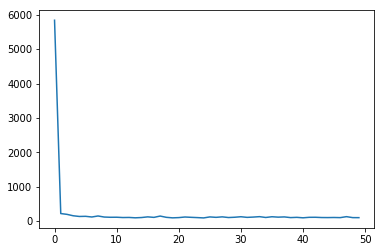

In [13]:
plt.plot(range(len(losses)), losses)

In [21]:
W1.value

array([[-2.86478673e+00, -9.12061528e-02,  4.72832534e+00,
        -1.00690236e+00, -4.17328808e-01, -4.01791757e+00,
        -6.21387121e+00,  3.39641756e+00, -2.35800519e+00,
        -4.74132430e+00],
       [-1.26799123e+00,  6.12460143e-01,  1.24006894e+00,
         1.02582297e+01, -2.09094828e+00, -2.25586404e+00,
         5.43711422e-01,  2.78737886e-01,  1.56302042e+00,
        -2.99611355e+00],
       [-2.09935822e+00,  3.58311644e-01,  3.78739950e-02,
        -1.78443635e+00, -7.59014491e-01,  3.63068332e+00,
         3.87862821e+00, -8.91975135e-01, -2.63772852e+00,
        -3.38119487e+00],
       [ 5.03215742e-03, -9.03277573e-02,  7.56025986e-01,
        -9.22027736e+00, -2.04035117e-01, -6.73106668e-02,
         4.81640928e+00,  9.42220822e+00,  2.08484859e-01,
        -2.59837318e-01],
       [-6.11313936e+00, -3.38393468e+00,  1.46329167e+00,
        -6.68353823e+00,  4.40503617e-01,  3.53597598e+00,
         6.85704091e+00, -4.83697984e+00, -1.46922091e+00,
        -5.

In [27]:
W2.value

array([[ 4.69300742],
       [10.89054967],
       [11.20597152],
       [ 8.47233219],
       [ 8.3942507 ],
       [ 5.73915137],
       [ 3.87041685],
       [ 6.34516404],
       [ 8.49914886],
       [ 6.3360908 ]])

In [28]:
X_ = data['data']

In [29]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [30]:
import keras

In [31]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [32]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [33]:
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 0s 144us/step - loss: 156.4277 - mse: 156.4277
Epoch 2/5000
506/506 [==============================] - 0s 38us/step - loss: 80.6683 - mse: 80.6683
Epoch 3/5000
506/506 [==============================] - 0s 42us/step - loss: 80.4446 - mse: 80.4446
Epoch 4/5000
506/506 [==============================] - 0s 63us/step - loss: 82.2151 - mse: 82.2151
Epoch 5/5000
506/506 [==============================] - 0s 51us/step - loss: 83.6360 - mse: 83.6360
Epoch 6/5000
506/506 [==============================] - 0s 55us/step - loss: 81.3844 - mse: 81.3844
Epoch 7/5000
506/506 [==============================] - 0s 57us/step - loss: 78.1012 - mse: 78.1012
Epoch 8/5000
506/506 [==============================] - 0s 74us/step - loss: 79.6823 - mse: 79.6823
Epoch 9/5000
506/506 [==============================] - 0s 63us/step - loss: 88.4547 - mse: 88.4547
Epoch 10/5000
506/506 [==============================] - 0s 53us/step - loss: 81.0215 - mse: 81.0

506/506 [==============================] - 0s 66us/step - loss: 77.9812 - mse: 77.9812
Epoch 163/5000
506/506 [==============================] - 0s 74us/step - loss: 78.2870 - mse: 78.2870
Epoch 164/5000
506/506 [==============================] - 0s 51us/step - loss: 77.7881 - mse: 77.7882
Epoch 165/5000
506/506 [==============================] - 0s 47us/step - loss: 78.4754 - mse: 78.4754
Epoch 166/5000
506/506 [==============================] - 0s 53us/step - loss: 77.8042 - mse: 77.8042
Epoch 167/5000
506/506 [==============================] - 0s 46us/step - loss: 78.0224 - mse: 78.0224
Epoch 168/5000
506/506 [==============================] - 0s 49us/step - loss: 78.2084 - mse: 78.2084
Epoch 169/5000
506/506 [==============================] - 0s 59us/step - loss: 78.3519 - mse: 78.3519
Epoch 170/5000
506/506 [==============================] - 0s 46us/step - loss: 78.2923 - mse: 78.2923
Epoch 171/5000
506/506 [==============================] - 0s 46us/step - loss: 77.0579 - mse: 77.

506/506 [==============================] - 0s 46us/step - loss: 78.5147 - mse: 78.5147
Epoch 323/5000
506/506 [==============================] - 0s 47us/step - loss: 78.4941 - mse: 78.4941
Epoch 324/5000
506/506 [==============================] - 0s 49us/step - loss: 77.8598 - mse: 77.8598
Epoch 325/5000
506/506 [==============================] - 0s 51us/step - loss: 78.0171 - mse: 78.0171
Epoch 326/5000
506/506 [==============================] - 0s 59us/step - loss: 77.7706 - mse: 77.7706
Epoch 327/5000
506/506 [==============================] - 0s 49us/step - loss: 77.8505 - mse: 77.8506
Epoch 328/5000
506/506 [==============================] - 0s 55us/step - loss: 77.5380 - mse: 77.5380
Epoch 329/5000
506/506 [==============================] - 0s 44us/step - loss: 78.1151 - mse: 78.1151
Epoch 330/5000
506/506 [==============================] - 0s 51us/step - loss: 78.1462 - mse: 78.1461
Epoch 331/5000
506/506 [==============================] - 0s 47us/step - loss: 78.2431 - mse: 78.

506/506 [==============================] - 0s 46us/step - loss: 77.9102 - mse: 77.9102
Epoch 483/5000
506/506 [==============================] - 0s 44us/step - loss: 77.9489 - mse: 77.9489
Epoch 484/5000
506/506 [==============================] - 0s 44us/step - loss: 77.7108 - mse: 77.7108
Epoch 485/5000
506/506 [==============================] - 0s 38us/step - loss: 78.0745 - mse: 78.0745
Epoch 486/5000
506/506 [==============================] - 0s 42us/step - loss: 78.0377 - mse: 78.0377
Epoch 487/5000
506/506 [==============================] - 0s 46us/step - loss: 77.6096 - mse: 77.6096
Epoch 488/5000
506/506 [==============================] - 0s 49us/step - loss: 78.0079 - mse: 78.0079
Epoch 489/5000
506/506 [==============================] - 0s 36us/step - loss: 77.8612 - mse: 77.8612
Epoch 490/5000
506/506 [==============================] - 0s 55us/step - loss: 78.0314 - mse: 78.0314
Epoch 491/5000
506/506 [==============================] - 0s 59us/step - loss: 77.8752 - mse: 77.

506/506 [==============================] - 0s 38us/step - loss: 78.3475 - mse: 78.3475
Epoch 643/5000
506/506 [==============================] - 0s 44us/step - loss: 77.6498 - mse: 77.6498
Epoch 644/5000
506/506 [==============================] - 0s 38us/step - loss: 78.0127 - mse: 78.0127
Epoch 645/5000
506/506 [==============================] - 0s 42us/step - loss: 77.9425 - mse: 77.9425
Epoch 646/5000
506/506 [==============================] - 0s 40us/step - loss: 77.9777 - mse: 77.9777
Epoch 647/5000
506/506 [==============================] - 0s 40us/step - loss: 77.7725 - mse: 77.7725
Epoch 648/5000
506/506 [==============================] - 0s 47us/step - loss: 77.6776 - mse: 77.6776
Epoch 649/5000
506/506 [==============================] - 0s 44us/step - loss: 77.8648 - mse: 77.8648
Epoch 650/5000
506/506 [==============================] - 0s 42us/step - loss: 77.9448 - mse: 77.9448
Epoch 651/5000
506/506 [==============================] - 0s 42us/step - loss: 78.8206 - mse: 78.

506/506 [==============================] - 0s 55us/step - loss: 78.1940 - mse: 78.1940
Epoch 803/5000
506/506 [==============================] - 0s 51us/step - loss: 78.1344 - mse: 78.1344
Epoch 804/5000
506/506 [==============================] - 0s 44us/step - loss: 77.6101 - mse: 77.6101
Epoch 805/5000
506/506 [==============================] - 0s 44us/step - loss: 77.8462 - mse: 77.8462
Epoch 806/5000
506/506 [==============================] - 0s 44us/step - loss: 78.0604 - mse: 78.0604
Epoch 807/5000
506/506 [==============================] - 0s 55us/step - loss: 77.4845 - mse: 77.4846
Epoch 808/5000
506/506 [==============================] - 0s 51us/step - loss: 77.9528 - mse: 77.9528
Epoch 809/5000
506/506 [==============================] - 0s 42us/step - loss: 77.8535 - mse: 77.8535
Epoch 810/5000
506/506 [==============================] - 0s 44us/step - loss: 77.4979 - mse: 77.4979
Epoch 811/5000
506/506 [==============================] - 0s 49us/step - loss: 78.6698 - mse: 78.

506/506 [==============================] - 0s 76us/step - loss: 77.5694 - mse: 77.5694
Epoch 963/5000
506/506 [==============================] - 0s 61us/step - loss: 77.7438 - mse: 77.7438
Epoch 964/5000
506/506 [==============================] - 0s 49us/step - loss: 78.4656 - mse: 78.4656
Epoch 965/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5746 - mse: 77.5746
Epoch 966/5000
506/506 [==============================] - 0s 49us/step - loss: 77.4249 - mse: 77.4249
Epoch 967/5000
506/506 [==============================] - 0s 46us/step - loss: 77.5705 - mse: 77.5705
Epoch 968/5000
506/506 [==============================] - 0s 44us/step - loss: 78.2002 - mse: 78.2002
Epoch 969/5000
506/506 [==============================] - 0s 44us/step - loss: 77.6481 - mse: 77.6481
Epoch 970/5000
506/506 [==============================] - 0s 44us/step - loss: 78.0507 - mse: 78.0507
Epoch 971/5000
506/506 [==============================] - 0s 49us/step - loss: 78.0155 - mse: 78.

506/506 [==============================] - 0s 46us/step - loss: 77.7662 - mse: 77.7662
Epoch 1043/5000
506/506 [==============================] - 0s 44us/step - loss: 78.1551 - mse: 78.1551
Epoch 1044/5000
506/506 [==============================] - 0s 51us/step - loss: 77.8792 - mse: 77.8792
Epoch 1045/5000
506/506 [==============================] - 0s 57us/step - loss: 77.7832 - mse: 77.7832
Epoch 1046/5000
506/506 [==============================] - 0s 53us/step - loss: 77.8947 - mse: 77.8947
Epoch 1047/5000
506/506 [==============================] - 0s 42us/step - loss: 77.5130 - mse: 77.5130
Epoch 1048/5000
506/506 [==============================] - 0s 38us/step - loss: 78.3536 - mse: 78.3536
Epoch 1049/5000
506/506 [==============================] - 0s 49us/step - loss: 77.5830 - mse: 77.5830
Epoch 1050/5000
506/506 [==============================] - 0s 42us/step - loss: 78.1165 - mse: 78.1165
Epoch 1051/5000
506/506 [==============================] - 0s 42us/step - loss: 77.5120 -

506/506 [==============================] - 0s 49us/step - loss: 77.5753 - mse: 77.5753
Epoch 1201/5000
506/506 [==============================] - 0s 51us/step - loss: 77.7748 - mse: 77.7748
Epoch 1202/5000
506/506 [==============================] - 0s 59us/step - loss: 78.0883 - mse: 78.0883
Epoch 1203/5000
506/506 [==============================] - 0s 40us/step - loss: 78.1796 - mse: 78.1795
Epoch 1204/5000
506/506 [==============================] - 0s 40us/step - loss: 77.7053 - mse: 77.7053
Epoch 1205/5000
506/506 [==============================] - 0s 40us/step - loss: 77.7615 - mse: 77.7615
Epoch 1206/5000
506/506 [==============================] - 0s 40us/step - loss: 77.6527 - mse: 77.6527
Epoch 1207/5000
506/506 [==============================] - 0s 42us/step - loss: 78.1552 - mse: 78.1552
Epoch 1208/5000
506/506 [==============================] - 0s 47us/step - loss: 77.6560 - mse: 77.6560
Epoch 1209/5000
506/506 [==============================] - 0s 57us/step - loss: 77.4679 -

506/506 [==============================] - 0s 55us/step - loss: 77.6544 - mse: 77.6544
Epoch 1359/5000
506/506 [==============================] - 0s 42us/step - loss: 77.7312 - mse: 77.7312
Epoch 1360/5000
506/506 [==============================] - 0s 38us/step - loss: 77.7982 - mse: 77.7982
Epoch 1361/5000
506/506 [==============================] - 0s 38us/step - loss: 77.7251 - mse: 77.7251
Epoch 1362/5000
506/506 [==============================] - 0s 38us/step - loss: 78.2572 - mse: 78.2571
Epoch 1363/5000
506/506 [==============================] - 0s 38us/step - loss: 77.9846 - mse: 77.9846
Epoch 1364/5000
506/506 [==============================] - 0s 36us/step - loss: 77.6070 - mse: 77.6070
Epoch 1365/5000
506/506 [==============================] - 0s 38us/step - loss: 77.1761 - mse: 77.1761
Epoch 1366/5000
506/506 [==============================] - 0s 38us/step - loss: 77.7619 - mse: 77.7619
Epoch 1367/5000
506/506 [==============================] - 0s 40us/step - loss: 77.5527 -

506/506 [==============================] - 0s 38us/step - loss: 77.7953 - mse: 77.7953
Epoch 1517/5000
506/506 [==============================] - 0s 47us/step - loss: 78.0073 - mse: 78.0073
Epoch 1518/5000
506/506 [==============================] - 0s 57us/step - loss: 77.7861 - mse: 77.7861
Epoch 1519/5000
506/506 [==============================] - 0s 51us/step - loss: 77.9890 - mse: 77.9890
Epoch 1520/5000
506/506 [==============================] - 0s 66us/step - loss: 77.9159 - mse: 77.9159
Epoch 1521/5000
506/506 [==============================] - 0s 38us/step - loss: 77.7310 - mse: 77.7310
Epoch 1522/5000
506/506 [==============================] - 0s 47us/step - loss: 77.9101 - mse: 77.9101
Epoch 1523/5000
506/506 [==============================] - 0s 46us/step - loss: 77.6565 - mse: 77.6565
Epoch 1524/5000
506/506 [==============================] - 0s 40us/step - loss: 77.7870 - mse: 77.7870
Epoch 1525/5000
506/506 [==============================] - 0s 47us/step - loss: 77.6498 -

506/506 [==============================] - 0s 46us/step - loss: 77.8054 - mse: 77.8054
Epoch 1675/5000
506/506 [==============================] - 0s 44us/step - loss: 77.7631 - mse: 77.7631
Epoch 1676/5000
506/506 [==============================] - 0s 40us/step - loss: 77.9600 - mse: 77.9600
Epoch 1677/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6865 - mse: 77.6865
Epoch 1678/5000
506/506 [==============================] - 0s 38us/step - loss: 77.8685 - mse: 77.8685
Epoch 1679/5000
506/506 [==============================] - 0s 42us/step - loss: 78.0281 - mse: 78.0281
Epoch 1680/5000
506/506 [==============================] - 0s 36us/step - loss: 77.8900 - mse: 77.8900
Epoch 1681/5000
506/506 [==============================] - 0s 38us/step - loss: 77.9965 - mse: 77.9965
Epoch 1682/5000
506/506 [==============================] - 0s 36us/step - loss: 77.5576 - mse: 77.5576
Epoch 1683/5000
506/506 [==============================] - 0s 40us/step - loss: 77.5552 -

506/506 [==============================] - 0s 47us/step - loss: 77.5018 - mse: 77.5018
Epoch 1833/5000
506/506 [==============================] - 0s 49us/step - loss: 77.5863 - mse: 77.5863
Epoch 1834/5000
506/506 [==============================] - 0s 44us/step - loss: 77.8098 - mse: 77.8098
Epoch 1835/5000
506/506 [==============================] - 0s 49us/step - loss: 77.6287 - mse: 77.6287
Epoch 1836/5000
506/506 [==============================] - 0s 51us/step - loss: 77.6748 - mse: 77.6748
Epoch 1837/5000
506/506 [==============================] - ETA: 0s - loss: 101.9495 - mse: 101.949 - 0s 47us/step - loss: 77.7562 - mse: 77.7562
Epoch 1838/5000
506/506 [==============================] - 0s 38us/step - loss: 77.5627 - mse: 77.5627
Epoch 1839/5000
506/506 [==============================] - 0s 44us/step - loss: 77.6223 - mse: 77.6223
Epoch 1840/5000
506/506 [==============================] - 0s 40us/step - loss: 77.7350 - mse: 77.7350
Epoch 1841/5000
506/506 [======================

506/506 [==============================] - 0s 34us/step - loss: 77.5507 - mse: 77.5507
Epoch 1991/5000
506/506 [==============================] - 0s 46us/step - loss: 77.5891 - mse: 77.5891
Epoch 1992/5000
506/506 [==============================] - 0s 40us/step - loss: 77.8115 - mse: 77.8115
Epoch 1993/5000
506/506 [==============================] - 0s 40us/step - loss: 77.6068 - mse: 77.6068
Epoch 1994/5000
506/506 [==============================] - 0s 68us/step - loss: 77.8482 - mse: 77.8482
Epoch 1995/5000
506/506 [==============================] - 0s 46us/step - loss: 77.9145 - mse: 77.9145
Epoch 1996/5000
506/506 [==============================] - 0s 38us/step - loss: 77.7018 - mse: 77.7018
Epoch 1997/5000
506/506 [==============================] - 0s 36us/step - loss: 77.5280 - mse: 77.5280
Epoch 1998/5000
506/506 [==============================] - 0s 38us/step - loss: 77.9712 - mse: 77.9712
Epoch 1999/5000
506/506 [==============================] - 0s 38us/step - loss: 77.8777 -

506/506 [==============================] - 0s 74us/step - loss: 77.7632 - mse: 77.7632
Epoch 2149/5000
506/506 [==============================] - 0s 51us/step - loss: 77.7892 - mse: 77.7892
Epoch 2150/5000
506/506 [==============================] - 0s 49us/step - loss: 77.8229 - mse: 77.8229
Epoch 2151/5000
506/506 [==============================] - 0s 49us/step - loss: 78.0152 - mse: 78.0152
Epoch 2152/5000
506/506 [==============================] - 0s 44us/step - loss: 78.1214 - mse: 78.1214
Epoch 2153/5000
506/506 [==============================] - 0s 34us/step - loss: 77.6325 - mse: 77.6325
Epoch 2154/5000
506/506 [==============================] - 0s 47us/step - loss: 77.7721 - mse: 77.7721
Epoch 2155/5000
506/506 [==============================] - 0s 51us/step - loss: 77.9940 - mse: 77.9940
Epoch 2156/5000
506/506 [==============================] - 0s 55us/step - loss: 77.6519 - mse: 77.6519
Epoch 2157/5000
506/506 [==============================] - 0s 42us/step - loss: 77.8036 -

506/506 [==============================] - 0s 42us/step - loss: 78.1086 - mse: 78.1086
Epoch 2307/5000
506/506 [==============================] - 0s 46us/step - loss: 77.8958 - mse: 77.8958
Epoch 2308/5000
506/506 [==============================] - 0s 46us/step - loss: 77.7178 - mse: 77.7178
Epoch 2309/5000
506/506 [==============================] - 0s 42us/step - loss: 77.5516 - mse: 77.5516
Epoch 2310/5000
506/506 [==============================] - 0s 38us/step - loss: 77.9508 - mse: 77.9508
Epoch 2311/5000
506/506 [==============================] - 0s 63us/step - loss: 77.7413 - mse: 77.7413
Epoch 2312/5000
506/506 [==============================] - 0s 40us/step - loss: 78.1559 - mse: 78.1559
Epoch 2313/5000
506/506 [==============================] - 0s 42us/step - loss: 77.7139 - mse: 77.7139
Epoch 2314/5000
506/506 [==============================] - 0s 44us/step - loss: 77.9858 - mse: 77.9858
Epoch 2315/5000
506/506 [==============================] - 0s 38us/step - loss: 78.3667 -

506/506 [==============================] - 0s 53us/step - loss: 77.6585 - mse: 77.6585
Epoch 2465/5000
506/506 [==============================] - 0s 51us/step - loss: 78.3655 - mse: 78.3655
Epoch 2466/5000
506/506 [==============================] - 0s 57us/step - loss: 77.8337 - mse: 77.8337
Epoch 2467/5000
506/506 [==============================] - 0s 55us/step - loss: 77.6563 - mse: 77.6563
Epoch 2468/5000
506/506 [==============================] - 0s 55us/step - loss: 77.5885 - mse: 77.5885
Epoch 2469/5000
506/506 [==============================] - 0s 47us/step - loss: 77.7973 - mse: 77.7973
Epoch 2470/5000
506/506 [==============================] - 0s 38us/step - loss: 77.8682 - mse: 77.8682
Epoch 2471/5000
506/506 [==============================] - 0s 40us/step - loss: 77.6810 - mse: 77.6810
Epoch 2472/5000
506/506 [==============================] - 0s 36us/step - loss: 77.8675 - mse: 77.8675
Epoch 2473/5000
506/506 [==============================] - 0s 34us/step - loss: 77.8680 -

506/506 [==============================] - 0s 53us/step - loss: 78.0165 - mse: 78.0164
Epoch 2623/5000
506/506 [==============================] - 0s 46us/step - loss: 77.6050 - mse: 77.6050
Epoch 2624/5000
506/506 [==============================] - 0s 44us/step - loss: 77.9727 - mse: 77.9727
Epoch 2625/5000
506/506 [==============================] - 0s 74us/step - loss: 77.3316 - mse: 77.3316
Epoch 2626/5000
506/506 [==============================] - 0s 40us/step - loss: 77.8963 - mse: 77.8963
Epoch 2627/5000
506/506 [==============================] - 0s 47us/step - loss: 77.5369 - mse: 77.5369
Epoch 2628/5000
506/506 [==============================] - 0s 49us/step - loss: 77.7943 - mse: 77.7943
Epoch 2629/5000
506/506 [==============================] - 0s 49us/step - loss: 77.5227 - mse: 77.5228
Epoch 2630/5000
506/506 [==============================] - 0s 80us/step - loss: 77.6663 - mse: 77.6663
Epoch 2631/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6294 -

506/506 [==============================] - 0s 40us/step - loss: 77.7635 - mse: 77.7636
Epoch 2780/5000
506/506 [==============================] - 0s 40us/step - loss: 77.8320 - mse: 77.8320
Epoch 2781/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6600 - mse: 77.6600
Epoch 2782/5000
506/506 [==============================] - 0s 44us/step - loss: 77.8496 - mse: 77.8496
Epoch 2783/5000
506/506 [==============================] - 0s 42us/step - loss: 78.0637 - mse: 78.0637
Epoch 2784/5000
506/506 [==============================] - 0s 38us/step - loss: 77.5110 - mse: 77.5110
Epoch 2785/5000
506/506 [==============================] - 0s 53us/step - loss: 77.7914 - mse: 77.7914
Epoch 2786/5000
506/506 [==============================] - 0s 47us/step - loss: 77.9045 - mse: 77.9045
Epoch 2787/5000
506/506 [==============================] - 0s 42us/step - loss: 77.4971 - mse: 77.4971
Epoch 2788/5000
506/506 [==============================] - 0s 40us/step - loss: 77.6477 -

506/506 [==============================] - 0s 53us/step - loss: 77.5973 - mse: 77.5973
Epoch 2938/5000
506/506 [==============================] - 0s 40us/step - loss: 77.8641 - mse: 77.8641
Epoch 2939/5000
506/506 [==============================] - 0s 44us/step - loss: 77.6157 - mse: 77.6157
Epoch 2940/5000
506/506 [==============================] - 0s 42us/step - loss: 77.6402 - mse: 77.6402
Epoch 2941/5000
506/506 [==============================] - 0s 34us/step - loss: 78.1466 - mse: 78.1466
Epoch 2942/5000
506/506 [==============================] - 0s 42us/step - loss: 78.0667 - mse: 78.0667
Epoch 2943/5000
506/506 [==============================] - 0s 42us/step - loss: 77.9041 - mse: 77.9041
Epoch 2944/5000
506/506 [==============================] - 0s 57us/step - loss: 77.8362 - mse: 77.8362
Epoch 2945/5000
506/506 [==============================] - 0s 53us/step - loss: 77.4700 - mse: 77.4700
Epoch 2946/5000
506/506 [==============================] - 0s 55us/step - loss: 77.6538 -

506/506 [==============================] - 0s 44us/step - loss: 77.5374 - mse: 77.5374
Epoch 3096/5000
506/506 [==============================] - 0s 38us/step - loss: 77.7816 - mse: 77.7816
Epoch 3097/5000
506/506 [==============================] - 0s 38us/step - loss: 77.3977 - mse: 77.3977
Epoch 3098/5000
506/506 [==============================] - 0s 46us/step - loss: 78.0719 - mse: 78.0719
Epoch 3099/5000
506/506 [==============================] - 0s 40us/step - loss: 78.2540 - mse: 78.2540
Epoch 3100/5000
506/506 [==============================] - 0s 36us/step - loss: 78.1634 - mse: 78.1634
Epoch 3101/5000
506/506 [==============================] - 0s 40us/step - loss: 77.4120 - mse: 77.4120
Epoch 3102/5000
506/506 [==============================] - 0s 53us/step - loss: 77.6828 - mse: 77.6828
Epoch 3103/5000
506/506 [==============================] - 0s 49us/step - loss: 77.6471 - mse: 77.6471
Epoch 3104/5000
506/506 [==============================] - 0s 44us/step - loss: 77.6654 -

506/506 [==============================] - 0s 63us/step - loss: 77.7528 - mse: 77.7528
Epoch 3254/5000
506/506 [==============================] - 0s 65us/step - loss: 77.6079 - mse: 77.6079
Epoch 3255/5000
506/506 [==============================] - 0s 89us/step - loss: 77.9725 - mse: 77.9725
Epoch 3256/5000
506/506 [==============================] - 0s 59us/step - loss: 77.8494 - mse: 77.8494
Epoch 3257/5000
506/506 [==============================] - 0s 72us/step - loss: 77.5529 - mse: 77.5529
Epoch 3258/5000
506/506 [==============================] - 0s 55us/step - loss: 77.6667 - mse: 77.6667
Epoch 3259/5000
506/506 [==============================] - 0s 61us/step - loss: 77.9644 - mse: 77.9644
Epoch 3260/5000
506/506 [==============================] - 0s 65us/step - loss: 77.4888 - mse: 77.4888
Epoch 3261/5000
506/506 [==============================] - 0s 63us/step - loss: 77.5129 - mse: 77.5129
Epoch 3262/5000
506/506 [==============================] - 0s 63us/step - loss: 77.7858 -

506/506 [==============================] - 0s 40us/step - loss: 77.6809 - mse: 77.6809
Epoch 3412/5000
506/506 [==============================] - 0s 44us/step - loss: 77.5106 - mse: 77.5106
Epoch 3413/5000
506/506 [==============================] - 0s 38us/step - loss: 77.4479 - mse: 77.4479
Epoch 3414/5000
506/506 [==============================] - 0s 40us/step - loss: 77.7073 - mse: 77.7073
Epoch 3415/5000
506/506 [==============================] - 0s 59us/step - loss: 78.2335 - mse: 78.2335
Epoch 3416/5000
506/506 [==============================] - 0s 46us/step - loss: 77.5652 - mse: 77.5652
Epoch 3417/5000
506/506 [==============================] - 0s 47us/step - loss: 77.4928 - mse: 77.4928
Epoch 3418/5000
506/506 [==============================] - 0s 47us/step - loss: 78.0922 - mse: 78.0922
Epoch 3419/5000
506/506 [==============================] - 0s 49us/step - loss: 77.5557 - mse: 77.5557
Epoch 3420/5000
506/506 [==============================] - 0s 44us/step - loss: 77.5762 -

506/506 [==============================] - 0s 38us/step - loss: 77.6664 - mse: 77.6664
Epoch 3570/5000
506/506 [==============================] - 0s 40us/step - loss: 77.4432 - mse: 77.4432
Epoch 3571/5000
506/506 [==============================] - 0s 42us/step - loss: 77.7015 - mse: 77.7015
Epoch 3572/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6537 - mse: 77.6537
Epoch 3573/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6414 - mse: 77.6414
Epoch 3574/5000
506/506 [==============================] - 0s 42us/step - loss: 77.6390 - mse: 77.6390
Epoch 3575/5000
506/506 [==============================] - 0s 70us/step - loss: 77.7224 - mse: 77.7224
Epoch 3576/5000
506/506 [==============================] - 0s 44us/step - loss: 78.0381 - mse: 78.0381
Epoch 3577/5000
506/506 [==============================] - 0s 42us/step - loss: 77.9023 - mse: 77.9023
Epoch 3578/5000
506/506 [==============================] - 0s 42us/step - loss: 77.8382 -

506/506 [==============================] - 0s 44us/step - loss: 77.8760 - mse: 77.8760
Epoch 3728/5000
506/506 [==============================] - 0s 44us/step - loss: 77.5302 - mse: 77.5302
Epoch 3729/5000
506/506 [==============================] - 0s 36us/step - loss: 77.6189 - mse: 77.6189
Epoch 3730/5000
506/506 [==============================] - 0s 42us/step - loss: 77.7504 - mse: 77.7504
Epoch 3731/5000
506/506 [==============================] - 0s 38us/step - loss: 77.4814 - mse: 77.4814
Epoch 3732/5000
506/506 [==============================] - 0s 42us/step - loss: 77.5208 - mse: 77.5208
Epoch 3733/5000
506/506 [==============================] - 0s 46us/step - loss: 77.3647 - mse: 77.3647
Epoch 3734/5000
506/506 [==============================] - ETA: 0s - loss: 101.1575 - mse: 101.157 - 0s 76us/step - loss: 77.6598 - mse: 77.6598
Epoch 3735/5000
506/506 [==============================] - 0s 46us/step - loss: 77.7253 - mse: 77.7253
Epoch 3736/5000
506/506 [======================

506/506 [==============================] - 0s 38us/step - loss: 77.6966 - mse: 77.6966
Epoch 3886/5000
506/506 [==============================] - 0s 38us/step - loss: 77.9302 - mse: 77.9302
Epoch 3887/5000
506/506 [==============================] - 0s 40us/step - loss: 77.5973 - mse: 77.5973
Epoch 3888/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6317 - mse: 77.6317
Epoch 3889/5000
506/506 [==============================] - 0s 42us/step - loss: 78.0300 - mse: 78.0300
Epoch 3890/5000
506/506 [==============================] - 0s 40us/step - loss: 77.6937 - mse: 77.6937
Epoch 3891/5000
506/506 [==============================] - 0s 40us/step - loss: 77.6606 - mse: 77.6606
Epoch 3892/5000
506/506 [==============================] - 0s 44us/step - loss: 77.4768 - mse: 77.4768
Epoch 3893/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6604 - mse: 77.6604
Epoch 3894/5000
506/506 [==============================] - 0s 46us/step - loss: 77.6283 -

506/506 [==============================] - 0s 40us/step - loss: 77.7229 - mse: 77.7229
Epoch 4044/5000
506/506 [==============================] - 0s 47us/step - loss: 77.6486 - mse: 77.6486
Epoch 4045/5000
506/506 [==============================] - 0s 40us/step - loss: 77.4070 - mse: 77.4070
Epoch 4046/5000
506/506 [==============================] - 0s 40us/step - loss: 77.9958 - mse: 77.9958
Epoch 4047/5000
506/506 [==============================] - 0s 38us/step - loss: 77.8203 - mse: 77.8203
Epoch 4048/5000
506/506 [==============================] - 0s 40us/step - loss: 77.8360 - mse: 77.8360
Epoch 4049/5000
506/506 [==============================] - 0s 40us/step - loss: 77.8820 - mse: 77.8820
Epoch 4050/5000
506/506 [==============================] - 0s 40us/step - loss: 77.7218 - mse: 77.7218
Epoch 4051/5000
506/506 [==============================] - 0s 42us/step - loss: 77.9243 - mse: 77.9243
Epoch 4052/5000
506/506 [==============================] - 0s 40us/step - loss: 78.0569 -

506/506 [==============================] - 0s 42us/step - loss: 77.9412 - mse: 77.9412
Epoch 4202/5000
506/506 [==============================] - 0s 42us/step - loss: 77.9637 - mse: 77.9637
Epoch 4203/5000
506/506 [==============================] - 0s 42us/step - loss: 77.4014 - mse: 77.4014
Epoch 4204/5000
506/506 [==============================] - 0s 42us/step - loss: 77.5461 - mse: 77.5461
Epoch 4205/5000
506/506 [==============================] - 0s 44us/step - loss: 77.8712 - mse: 77.8712
Epoch 4206/5000
506/506 [==============================] - 0s 40us/step - loss: 77.6050 - mse: 77.6050
Epoch 4207/5000
506/506 [==============================] - 0s 51us/step - loss: 77.3352 - mse: 77.3352
Epoch 4208/5000
506/506 [==============================] - 0s 70us/step - loss: 77.7856 - mse: 77.7856
Epoch 4209/5000
506/506 [==============================] - 0s 55us/step - loss: 77.8004 - mse: 77.8004
Epoch 4210/5000
506/506 [==============================] - 0s 40us/step - loss: 77.2792 -

506/506 [==============================] - 0s 49us/step - loss: 77.8618 - mse: 77.8618
Epoch 4360/5000
506/506 [==============================] - 0s 68us/step - loss: 77.3533 - mse: 77.3534
Epoch 4361/5000
506/506 [==============================] - 0s 53us/step - loss: 77.6519 - mse: 77.6519
Epoch 4362/5000
506/506 [==============================] - 0s 47us/step - loss: 77.6802 - mse: 77.6802
Epoch 4363/5000
506/506 [==============================] - 0s 44us/step - loss: 77.7484 - mse: 77.7484
Epoch 4364/5000
506/506 [==============================] - 0s 46us/step - loss: 77.5922 - mse: 77.5922
Epoch 4365/5000
506/506 [==============================] - 0s 34us/step - loss: 77.6724 - mse: 77.6724
Epoch 4366/5000
506/506 [==============================] - 0s 42us/step - loss: 77.8694 - mse: 77.8694
Epoch 4367/5000
506/506 [==============================] - 0s 47us/step - loss: 77.4379 - mse: 77.4379
Epoch 4368/5000
506/506 [==============================] - 0s 42us/step - loss: 77.6584 -

506/506 [==============================] - 0s 40us/step - loss: 77.5868 - mse: 77.5868
Epoch 4518/5000
506/506 [==============================] - 0s 38us/step - loss: 78.0139 - mse: 78.0139
Epoch 4519/5000
506/506 [==============================] - 0s 42us/step - loss: 77.9718 - mse: 77.9718
Epoch 4520/5000
506/506 [==============================] - 0s 49us/step - loss: 77.4835 - mse: 77.4835
Epoch 4521/5000
506/506 [==============================] - 0s 47us/step - loss: 77.5413 - mse: 77.5413
Epoch 4522/5000
506/506 [==============================] - 0s 57us/step - loss: 77.5607 - mse: 77.5607
Epoch 4523/5000
506/506 [==============================] - 0s 42us/step - loss: 77.8218 - mse: 77.8218
Epoch 4524/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6853 - mse: 77.6853
Epoch 4525/5000
506/506 [==============================] - 0s 44us/step - loss: 77.4157 - mse: 77.4157
Epoch 4526/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6409 -

506/506 [==============================] - 0s 53us/step - loss: 77.7668 - mse: 77.7668
Epoch 4676/5000
506/506 [==============================] - 0s 59us/step - loss: 77.6196 - mse: 77.6196
Epoch 4677/5000
506/506 [==============================] - 0s 46us/step - loss: 77.6566 - mse: 77.6567
Epoch 4678/5000
506/506 [==============================] - 0s 46us/step - loss: 78.0394 - mse: 78.0394
Epoch 4679/5000
506/506 [==============================] - 0s 55us/step - loss: 77.5927 - mse: 77.5927
Epoch 4680/5000
506/506 [==============================] - 0s 49us/step - loss: 77.4036 - mse: 77.4036
Epoch 4681/5000
506/506 [==============================] - 0s 42us/step - loss: 77.6994 - mse: 77.6994
Epoch 4682/5000
506/506 [==============================] - 0s 49us/step - loss: 77.4019 - mse: 77.4019
Epoch 4683/5000
506/506 [==============================] - 0s 63us/step - loss: 77.6333 - mse: 77.6333
Epoch 4684/5000
506/506 [==============================] - 0s 76us/step - loss: 78.0454 -

506/506 [==============================] - 0s 38us/step - loss: 77.5519 - mse: 77.5519
Epoch 4834/5000
506/506 [==============================] - 0s 40us/step - loss: 77.6597 - mse: 77.6597
Epoch 4835/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6478 - mse: 77.6478
Epoch 4836/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6504 - mse: 77.6504
Epoch 4837/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6702 - mse: 77.6702
Epoch 4838/5000
506/506 [==============================] - 0s 38us/step - loss: 77.8737 - mse: 77.8737
Epoch 4839/5000
506/506 [==============================] - 0s 34us/step - loss: 77.6848 - mse: 77.6848
Epoch 4840/5000
506/506 [==============================] - 0s 36us/step - loss: 77.9248 - mse: 77.9248
Epoch 4841/5000
506/506 [==============================] - 0s 40us/step - loss: 77.3580 - mse: 77.3580
Epoch 4842/5000
506/506 [==============================] - 0s 38us/step - loss: 77.4696 -

506/506 [==============================] - 0s 59us/step - loss: 77.4720 - mse: 77.4720
Epoch 4992/5000
506/506 [==============================] - 0s 65us/step - loss: 77.4939 - mse: 77.4940
Epoch 4993/5000
506/506 [==============================] - 0s 53us/step - loss: 77.3536 - mse: 77.3536
Epoch 4994/5000
506/506 [==============================] - 0s 44us/step - loss: 77.5894 - mse: 77.5894
Epoch 4995/5000
506/506 [==============================] - 0s 57us/step - loss: 77.7712 - mse: 77.7713
Epoch 4996/5000
506/506 [==============================] - 0s 47us/step - loss: 77.3552 - mse: 77.3552
Epoch 4997/5000
506/506 [==============================] - 0s 46us/step - loss: 77.6224 - mse: 77.6224
Epoch 4998/5000
506/506 [==============================] - 0s 40us/step - loss: 77.7229 - mse: 77.7229
Epoch 4999/5000
506/506 [==============================] - 0s 61us/step - loss: 77.6486 - mse: 77.6486
Epoch 5000/5000
506/506 [==============================] - 0s 40us/step - loss: 77.6221 -